In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline 

In [2]:
# inspiration from this great post
# https://www.kaggle.com/jeffd23/dogs-vs-cats-redux-kernels-edition/catdognet-keras-convnet-starter/comments

In [3]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
train_dir = 'train/'

img_size = (120,120,3)
dogs = [train_dir + i for i in os.listdir(train_dir) if 'dog' in i]
cats = [train_dir + i for i in os.listdir(train_dir) if 'cat' in i]
train = [train_dir + i for i in os.listdir(train_dir)]
labels = np.array([1 if 'dog' in x else 0 for x in os.listdir(train_dir)])

In [5]:
labels[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0])

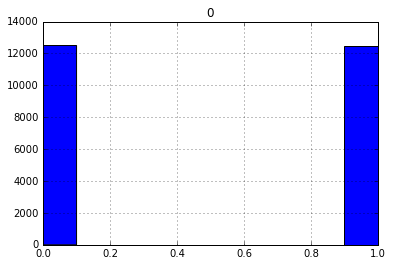

In [6]:
# even
_ = pd.DataFrame(labels).hist()

In [7]:
dogs[0:5]

['train/dog.5745.jpg',
 'train/dog.7922.jpg',
 'train/dog.8224.jpg',
 'train/dog.527.jpg',
 'train/dog.8996.jpg']

In [8]:
def read_image(f):
    img = cv2.imread(f,cv2.IMREAD_COLOR)
    return cv2.resize(img,(img_size[0],img_size[1]),interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, 3, 120, 120), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [9]:
train_data = prep_data(train)

Processed 0 of 25000
Processed 250 of 25000
Processed 500 of 25000
Processed 750 of 25000
Processed 1000 of 25000
Processed 1250 of 25000
Processed 1500 of 25000
Processed 1750 of 25000
Processed 2000 of 25000
Processed 2250 of 25000
Processed 2500 of 25000
Processed 2750 of 25000
Processed 3000 of 25000
Processed 3250 of 25000
Processed 3500 of 25000
Processed 3750 of 25000
Processed 4000 of 25000
Processed 4250 of 25000
Processed 4500 of 25000
Processed 4750 of 25000
Processed 5000 of 25000
Processed 5250 of 25000
Processed 5500 of 25000
Processed 5750 of 25000
Processed 6000 of 25000
Processed 6250 of 25000
Processed 6500 of 25000
Processed 6750 of 25000
Processed 7000 of 25000
Processed 7250 of 25000
Processed 7500 of 25000
Processed 7750 of 25000
Processed 8000 of 25000
Processed 8250 of 25000
Processed 8500 of 25000
Processed 8750 of 25000
Processed 9000 of 25000
Processed 9250 of 25000
Processed 9500 of 25000
Processed 9750 of 25000
Processed 10000 of 25000
Processed 10250 of 25

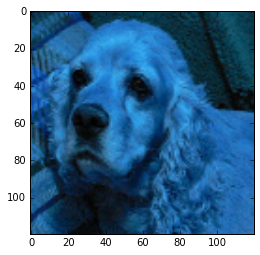

In [10]:
plt.imshow(read_image(dogs[8]))

#blue dogs?

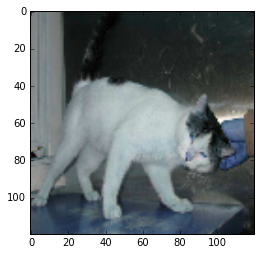

In [11]:
plt.imshow(read_image(cats[4]))

In [12]:
# correct shape!
train_data.shape

(25000, 3, 120, 120)

In [13]:
from __future__ import division
train_data = train_data / 255

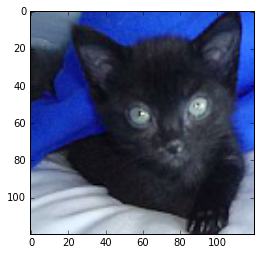

In [14]:
# lets see if our image makes it through reshaping
plt.imshow(train_data[0].T)

# Model from this paper

[Very Deep Conv Networks for Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [23]:
def mdl():
    model = Sequential()
    
    model.add(Convolution2D(32,3,3,border_mode='same',
                            input_shape=(3,120,120),activation='relu'))
    model.add(Convolution2D(32,3,3,border_mode='same',
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #################################################
    model.add(Convolution2D(64,3,3,border_mode='same',
                        activation='relu'))
    model.add(Convolution2D(64,3,3,border_mode='same',
                        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #################################################
    model.add(Convolution2D(128,3,3,border_mode='same',
                        activation='relu'))
    model.add(Convolution2D(128,3,3,border_mode='same',
                        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #################################################
    model.add(Convolution2D(256,3,3,border_mode='same',
                        activation='relu'))
    model.add(Convolution2D(256,3,3,border_mode='same',
                        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #################################################
    model.add(Convolution2D(256,3,3,border_mode='same',
                        activation='relu'))
    model.add(Convolution2D(256,3,3,border_mode='same',
                        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #################################################
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    #################################################
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=1e-4),
                 metrics = ['accuracy'])
    return model
mdl = mdl()

In [16]:
import datetime

In [17]:
train_data.dtype

dtype('float64')

In [18]:
now = datetime.datetime.now()
time = now.strftime('%Y_%m_%d_%H_%M_%S')


# wow callbacks are useful...
t_b = TensorBoard(log_dir = 'logs/'+time,histogram_freq = 20)
c_p = ModelCheckpoint('chck/weights.hdf5',verbose = 0,save_best_only=True) # really would be nice to not save always

train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2, height_shift_range = 0.2
                                   ,shear_range = 0.2, horizontal_flip = True)

train_datagen.fit(train_data) # do I need this?

train_generator = train_datagen.flow(train_data,labels,batch_size = 100)

valid_generator = train_datagen.flow(train_data,labels,batch_size = 500)

In [19]:
p_X,p_y = train_generator.next()

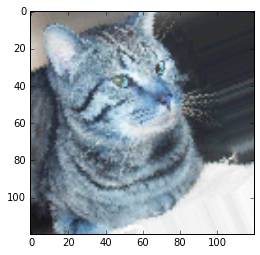

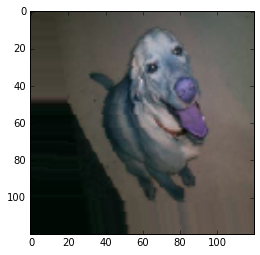

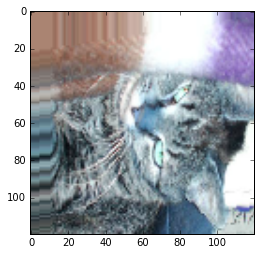

In [20]:
for i in range(3):
    plt.imshow(p_X[i].T)
    plt.figure()

In [ ]:
mdl.fit_generator(train_generator,
                  samples_per_epoch = 5000,
                  validation_data = valid_generator, #keras 1.06 ONLY # other one is busted
                  nb_val_samples = 10,
                  nb_epoch = 1000,
                  verbose = 0,
                  callbacks = [t_b,c_p])

# mdl.fit(train_data,labels,batch_size = batch_size,nb_epoch=nb_epoch,
#        validation_split = 0.25,verbose = 0, shuffle = True,
#        callbacks = [t_b,c_p])

In [ ]:
## model fit stats
predictions = mdl.predict(train_data, verbose=0)

In [ ]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(train_data[i])
    plt.show()